## Introduction

This analysis uses the <a href="https://www.kaggle.com/uciml/pima-indians-diabetes-database?select=diabetes.csv">Pima Indians Diabetes Dataset</a> downloaded from Kaggle.  It contains measurements of 768 women of Pima ancestry.  The target variable is whether or not they had diabetes.  The other 8 attributes are input variables.
    
In this notebook, we will attempt to train 3 different machine learning models to predict whether or not the patient has diabetes based on the other attributes given.  The algorithms used will be <a href="https://en.wikipedia.org/wiki/Logistic_regression">Logistic Regression</a>, <a href="https://en.wikipedia.org/wiki/Random_forest">Random Forests</a>, and <a href="https://en.wikipedia.org/wiki/Neural_network">Neural Networks</a>.  We will use scikit-learn for Logistic Regression and Random Forests.  For Neural Networks will will use Keras with Tensorflow underneath.

First, import the usual suspects.

In [1]:
# dataframes and plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# scikit-learn data splitting and prediction analysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
# the models used
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.


Show the versions being used.

In [4]:
import sklearn
print('sklearn', sklearn.__version__)
import keras
print('keras', keras.__version__)
import tensorflow
print('tensorflow', tensorflow.__version__)

sklearn 0.23.2
keras 2.3.1
tensorflow 2.0.0


<br>
<br>
<h2>The data set</h2>

Now, get the dataframe.  You could do <code>"diab = pd.read_csv('diabetes.csv')"</code>.  But I wrote a function that loads the data and changes the column names to all lower case letters (a personal preference - makes it easier to type).

In [5]:
def get_df(file_name):
    '''
    Load the dataset from the csv file.
    :return: a DataFrame containing the dataset
    '''
    diab = pd.read_csv(file_name)
    new_column_names = {}
    for column in diab.columns:
        new_column_names[column] = column.lower()
    diab = diab.rename(columns=new_column_names)
    return diab

In [6]:
diab = get_df('diabetes.csv')

In [7]:
diab.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
diab.outcome.value_counts()

0    500
1    268
Name: outcome, dtype: int64

In [9]:
diab.outcome.value_counts() / diab.shape[0]

0    0.651042
1    0.348958
Name: outcome, dtype: float64

So in this data set, 500 (about 65%) were not diagnosed as diabetic and 268 (about 35%) were.

I am interested to know how correlated each input variable is to the target variable.

<AxesSubplot:>

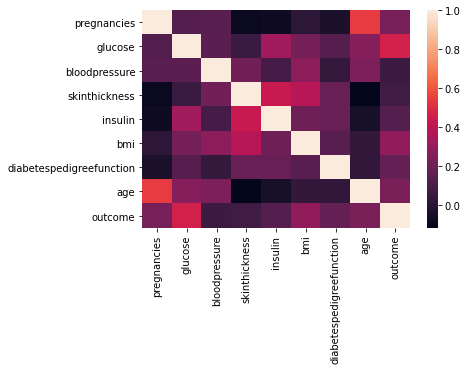

In [10]:
sns.heatmap(diab.corr())

This is a little difficult to read, especially if you are only intrested in correlations between the inputs and the target, not between inputs and other inputs, so let's list the correlations of each input to the target.

In [11]:
correlations = []
for column in diab.columns[:-1]:
    correlations.append((column,  diab.outcome.corr(diab[column])))
correlations.sort(key = lambda kv: kv[1], reverse=True)
correlations

[('glucose', 0.4665813983068733),
 ('bmi', 0.29269466264444505),
 ('age', 0.23835598302719765),
 ('pregnancies', 0.2218981530339865),
 ('diabetespedigreefunction', 0.17384406565295976),
 ('insulin', 0.13054795488404788),
 ('skinthickness', 0.07475223191831944),
 ('bloodpressure', 0.06506835955033273)]

<br>
<br>
<h2>Data Preparation</h2>

Before using some algorithms liks logistic regression and neural networks, it often works best to scan the columns, often to between -1 and 1 or 0 and 1.  Another possbility is to scale the values by how many standard deviations they are from the mean.

In [12]:
#diab.describe()

We do not use the standard deviation method here because most of the variables are not normally distributed.  (The easiest way to see that is to view a graph of all the variables, which is not included here to save space.)

In [13]:
def linear_scale_column(column):
    '''
    Scale the column so all the values are between 0 and 1.
    :param column:
    :return:
    '''
    column = pd.Series(column)  # make sure it is a series so we can do a vectorized operation
    min = column.min()
    max = column.max()
    column = column.apply(lambda n: (n - min) / (max - min))
    return column

In [14]:
for column_name in ['pregnancies',
 'glucose',
 'bloodpressure',
 'skinthickness',
 'insulin',
 'bmi',
 'diabetespedigreefunction',
 'age']:
    diab[column_name] = linear_scale_column(diab[column_name])

'''
Uncomment to show all the graphs.
for column in list(diab.columns[:-1]):
    if diab[column].dtype == 'int64':
        sns.countplot(diab[column])
    else:
        sns.distplot(diab[column])
    plt.show()
'''

In [15]:
#diab.describe()

So now they are all between 0 and 1.  The correlations are stil the same.

In [16]:
correlations = []
for column in diab.columns[:-1]:
    correlations.append((column,  diab.outcome.corr(diab[column])))
correlations.sort(key = lambda kv: kv[1], reverse=True)
correlations

[('glucose', 0.4665813983068734),
 ('bmi', 0.2926946626444452),
 ('age', 0.23835598302719743),
 ('pregnancies', 0.22189815303398672),
 ('diabetespedigreefunction', 0.17384406565295984),
 ('insulin', 0.1305479548840473),
 ('skinthickness', 0.0747522319183193),
 ('bloodpressure', 0.06506835955033263)]

For this data set, there was no other data manipulation necessary, so we can go on to training the algorithms.

<br>
<br>
<h2>Training the Algorithms</h2>

Now we'll start training algorithms and doing predictions.

The first step is to split the data into a training and testing set.

In [17]:
x_train, x_test, y_train, y_test = train_test_split(diab[diab.columns[:-1]], diab.outcome, test_size=.3, random_state=37)

To save some typing, let's make a function to do this.

In [18]:
def get_train_test_split(diab):
    '''
    Split the data into the train and test portions.  This function really isn't all that necessary in it's current
    form.  It just saves a little bit of typing.
    :param diab:
    :return: a four part tuple
    '''
    x_train, x_test, y_train, y_test = train_test_split(diab[diab.columns[:-1]], diab.outcome, test_size=.3, random_state=37)
    return x_train, x_test, y_train, y_test

<h3>Logistic Regression and Random Forests</h3>

Now, train and evaluate a Logistic Regression model.

In [19]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_predictions = lr.predict(x_test)
print(accuracy_score(y_test, lr_predictions))
print(confusion_matrix(y_test, lr_predictions))

0.7792207792207793
[[141  10]
 [ 41  39]]


So it gets almost 80% correct.  Let's compare it's prediction proportions to the real ones.

In [20]:
pd.Series(y_test).value_counts() / len(y_test)

0    0.65368
1    0.34632
Name: outcome, dtype: float64

In [21]:
pd.Series(lr_predictions).value_counts() / len(lr_predictions)

0    0.787879
1    0.212121
dtype: float64

So the Logistic Regression model is predicting more negatives than it should be.

Next, let's try Randoms Forests.  Since Random Forests have some randomness, the results can changes slightly from one run to the next.  So let's make a function to run the training and predicting so we can do it with just one line of code.

Now try Random Forests.

In [22]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_predictions = rf.predict(x_test)
print(accuracy_score(y_test, rf_predictions))
print(confusion_matrix(y_test, rf_predictions))

0.7662337662337663
[[135  16]
 [ 38  42]]


But due to the radomness involved, there is some variation in Random Forest training.  So it would be nice to be able to run a machine learning algorithm multiple times without having to type the same lines over and over again.  So let's write a few functions.

In [23]:
def do_one_run(model, x_train, x_test, y_train, y_test, print_only=False):
    '''
    Do one train / test cycle of the given model with the given data.
    :param model: the sklearn model
    :param x_train: the DataFrame holding the input variables of the training set
    :param x_test: the DataFrame holding the input variables of the test set
    :param y_train: the target column of the training set
    :param y_test: the target column of the test set
    :param print_only: whether you should print the results or return for later aggregation
    :return:
    '''
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    if print_only:
        show_accuracy_stats(y_test, predictions)
    else:
        return predictions


In [24]:
def do_random_forest_single(diab):
    '''
    Run one train / test cycle for Random Forests and print the results.
    :param diab: the DataFrame
    :return: nothing
    '''
    rf = RandomForestClassifier()
    x_train, x_test, y_train, y_test = get_train_test_split(diab)
    do_one_run(rf, x_train, x_test, y_train, y_test, True)

In [25]:
def do_logistic_single(diab):
    '''
    Run one train / test cycle for Logistic Regression and print the results.
    :param diab: the DataFrame
    :return:  nothing
    '''
    lr = LogisticRegression(max_iter=5000)
    x_train, x_test, y_train, y_test = get_train_test_split(diab)
    do_one_run(lr, x_train, x_test, y_train, y_test, True)

In [26]:
def show_accuracy_stats(y_test, predictions):
    print(accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test, predictions))

In [27]:
do_logistic_single(diab)

0.7792207792207793
[[141  10]
 [ 41  39]]


In [28]:
do_random_forest_single(diab)

0.7575757575757576
[[131  20]
 [ 36  44]]


In [29]:
do_random_forest_single(diab)

0.7489177489177489
[[133  18]
 [ 40  40]]


You see the slightly different results for Random Forests.

Now, let's write functions to run it multiple times and combine the results.

In [30]:
def aggregate_predictions(predictions_list, one_prob):
    '''
    :param predictions_list:
    :param one_prob: the probability of getting one, if you randomly choose 1 or 0
    :return:
    '''
    predictions_np = np.array(predictions_list)
    predictions_mean = (np.apply_along_axis(sum, 0, predictions_np) / predictions_np.shape[0]).reshape(1, predictions_np.shape[1])
    agg = np.apply_along_axis(lambda n: 1 if n > one_prob else (np.random.choice([1, 0], p=[one_prob, 1 - one_prob]) if n == one_prob else 0), 0, predictions_mean)
    return agg


In [31]:
def run_aggregations(model, x_train, x_test, y_train, y_test, the_function=do_one_run, num_runs=10):
    '''
    Run the model many times, using the given function, and aggregate the results.  Really, "average" might be the
    better word.
    Currently, the function parameter is not necessary.  I had intended this to be used for any of the model types
    (logistic, random forests, and neural networks), but neural networks required a slight different function,
    so I added the function parameter.  Then I discovered that the neural network algorithm needs a new model each
    time, so I just made the do_dnn_many() function to be the neural network equivalent of this function.
    :param model: The sklearn model.  In this case, either LogisticRegression or RandomForest.
    :param the_function: The function to use.
    :param num_runs: How many times to run it.
    :return:
    '''
    lists = []
    for i in range(num_runs):
        result = the_function(model, x_train, x_test, y_train, y_test)
        lists.append(result)
        #show_accuracy_stats(y_test, result)

    predictions_np = np.array(lists)
    one_prob = sum(y_test) / len(y_test)
    agg = aggregate_predictions(predictions_np, one_prob)
    print("\naggregate results:")
    show_accuracy_stats(y_test, agg)
    return agg

And functions to run Logistic Regression and Random Forests many times.

In [32]:
def do_logistic_many(diab):
    '''
    Do many train / test cycles of logistic regression.  Not really needed since it is the same for each run.
    :param diab:
    :return:
    '''
    print("\nrunning logistic regressions:")
    model = LogisticRegression(max_iter=5000)
    x_train, x_test, y_train, y_test = get_train_test_split(diab)
    return run_aggregations(model, x_train, x_test, y_train, y_test, the_function=do_one_run)

In [33]:
def do_random_forest_many(diab):
    '''
    Do many train / test cycles of Random Forests and print the aggregated results.
    :param diab:
    :return:
    '''
    print("\nrunning random forests:")
    model = RandomForestClassifier()
    x_train, x_test, y_train, y_test = get_train_test_split(diab)
    return run_aggregations(model, x_train, x_test, y_train, y_test, the_function=do_one_run)

In [34]:
rf = do_random_forest_many(diab)


running random forests:

aggregate results:
0.7619047619047619
[[131  20]
 [ 35  45]]


In [35]:
lg = do_logistic_many(diab)


running logistic regressions:

aggregate results:
0.7792207792207793
[[141  10]
 [ 41  39]]


It seems that the Logistic Regression results do not change from one run to the next.

<h3>Neural Networks</h3>

And now let's turn our attention to Neural Networks.

I'll create a simple Neural Network model with 8 inputs (one for each independent variable).  We can change the number of layers based on a parameter in the function below, and the number of nodes in the hidden layers can also be specified.  Foe example, a call to make_dnn_model(2, 4) will lead to a network with 8 input nodes, a layer with 32 nodes, another layer with 32 nodes, and an output layer.

As with Random Forests, there is some randomness involved in training the neural network so the results are not deterministic.  So I'll make functions to run it multiple times.  Because the Neural Network is run in a slightly different way that the Random Forest, I can't reuse the run_aggregations() function from before, so do_dnn_many will combine the work of run_X_many() and run_aggregations().

In [36]:
def make_dnn_model(num_layers, layer_size_ratio):
    '''
    make a very simple, or even simplistic, neural network model
    :param num_layers: how many layers
    :param layer_size_ratio: ratio of size of middle layers to the input layer
    :return:
    '''
    model = Sequential()
    layer_width = 8 * layer_size_ratio
    # TODO:  Don't hard code 8 (the number of input variables in this particular case) in here
    model.add(Dense(layer_width, input_dim=8, activation='relu'))
    for i in range(num_layers - 1):
        model.add(Dense(layer_width, input_dim=layer_width, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [37]:
def do_one_dnn_run(model, x_train, x_test, y_train, y_test, num_epochs=100, print_only=False):
    '''
    Do one train / test run of the given neural network model.
    :param num_epochs: how many epochs to use in the neural network training
    :param print_only: to print the results or return them for aggregation later
    :return:
    '''
    y_binary = to_categorical(y_train)
    model.fit(x_train, y_binary, epochs=num_epochs, verbose=0)

    dnn_predictions = model.predict(x_test)

    pred = np.apply_along_axis(lambda r: 1 if r[1] > r[0] else 0, 1, dnn_predictions)
    if print_only:
        show_accuracy_stats(y_test, pred)
    else:
        return pred

In [38]:
def do_dnn_single(diab):
    '''
    Make a DNN model and run it once.
    :param diab:
    :return:
    '''
    model = make_dnn_model(5, 4)
    x_train, x_test, y_train, y_test = get_train_test_split(diab)
    do_one_dnn_run(model, x_train, x_test, y_train, y_test, print_only=True)

In [39]:
def do_dnn_many(diab, num_runs=10, num_layers=5, layer_size_ratio=4):
    '''
    Run the DNN train / test cycle many times and aggregate the results.
    :param diab:
    :return:
    '''
    print("\ndoing DNN:")
    x_train, x_test, y_train, y_test = get_train_test_split(diab)
    lists = []
    for i in range(num_runs):
        model = make_dnn_model(num_layers, layer_size_ratio)
        result = do_one_dnn_run(model, x_train, x_test, y_train, y_test)
        lists.append(result)
        #show_accuracy_stats(y_test, result)

    predictions_np = np.array(lists)
    one_prob = sum(y_test) / len(y_test)
    agg = aggregate_predictions(predictions_np, one_prob)
    print("\naggregate results:")
    show_accuracy_stats(y_test, agg)
    return agg

In [40]:
dnn_predictions_5_4 = do_dnn_many(diab, 5, 4)


doing DNN:

aggregate results:
0.7489177489177489
[[114  37]
 [ 21  59]]


In [41]:
dnn_predictions_10_2 = do_dnn_many(diab, 10, 2)


doing DNN:

aggregate results:
0.7878787878787878
[[133  18]
 [ 31  49]]


In [42]:
dnn_predictions_10_4 = do_dnn_many(diab, 10, 4)


doing DNN:

aggregate results:
0.7359307359307359
[[117  34]
 [ 27  53]]


From the few examples I have tried, (10, 2) seems the best parameter set.

<br>
<br>
<h2>Comparing the three algorithms</h2>

Now let's look at each of them together, and the aggregated results from all three.

In [43]:
lg_predictions = do_logistic_many(diab)
rf_predictions = do_random_forest_many(diab)
dnn_predictions = do_dnn_many(diab, 10, 2)
agg = aggregate_predictions([lg_predictions, rf_predictions, dnn_predictions], 0.348958)


running logistic regressions:

aggregate results:
0.7792207792207793
[[141  10]
 [ 41  39]]

running random forests:

aggregate results:
0.7489177489177489
[[131  20]
 [ 38  42]]

doing DNN:

aggregate results:
0.7748917748917749
[[129  22]
 [ 30  50]]


In [44]:
show_accuracy_stats(y_test, agg)

0.7835497835497836
[[135  16]
 [ 34  46]]


## Conclusion:
    
In this dataset, using a Logistic Regression model with scikit-learn, we can predict whether or not a woman was diagnosed with diabetes, based on the other variables given, with about 77.9% accuracy.  Logistic Regression was more accurate than Random Forests and most of the attemps with Neural Networks.

In my observations of the Machine Learning community, it seems that Neural Networks and Random Forests are very popular algorithms.  And they do perform well in many circumstances.  However, in this case, they did not outperform Logistic Regression and take more time and electricity to train (especially Neural Networks).    I don't have much experience with Neural Networks thought, so I remain very open to the possibility that there is a better way to set up and run the network.

However despite Logistic Regression having a higher accuracy score, more True Negatives, and fewer False Positives, it does have more False Negatives and fewer True Positives than the others.  It seems that among the cases that actually are Negatives (that is, women without diabetes, which almost 2/3 are), Logistic Regression does the best job of determining that it is negative.  But for those that are positive, Random Forests and Neural Netorks do a better job.

In a medical diagnosis, a False Negative could be more harmful than a False Positive.  It could depend on the illness and what actions are taken after a positive diagnosis (retest, invasive treatment, etc.).  But False Positives can be dangerous if they lead someone who is sick to not get treatment.

So if False Negatives are a greater problem than False Positives, then Logisitc Regression may not be the best algorithm to use in this case, even though it is slightly more accurate.

One possible candidate would be the aggregation of all three models, which has an overall accuracy nearly identical to Logistic Regression but with fewer False Negatives.

<h3>For further research:</h3>

<ul>
    <li>More experimenting with Neural Networks.  I am still someone new to it.</li>
    <li>Experiment with parameter tuning on Random Forests.</li>
    <li>A similar analysis with a larger data set.</li>
    <li>Train with different train/test splits.</li>
    <li>Principal Component Analysis - can we get it down from 8 inputs to, say, 5?</li>
</ul>
    